# z5109981 MTRN4110 Assignment Part C

In [1]:
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plottin

Maze="../Maze_2.png"
Rob="../Robot_2.png"
Map="../MapFound.txt"

## Load Maze

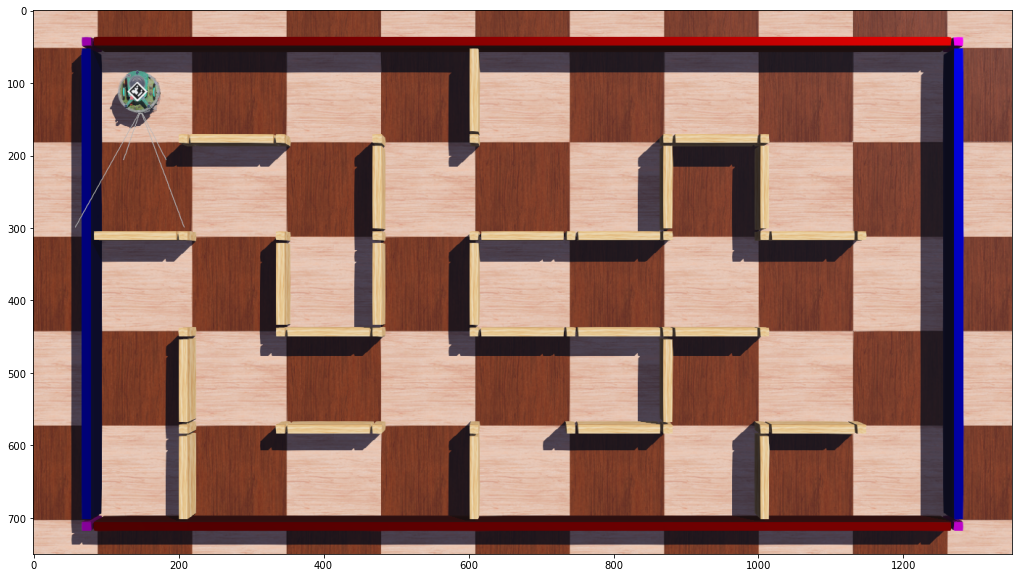

In [2]:
#Load Images
img = cv2.imread(Maze)
ROI = cv2.imread(Rob)

#Maze Colour Schemes
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert Default BGR to RGB (Visual Aspect)
img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)  # Convert Default BGR to HSV (Analysis Aspect)
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)# Convert Default BGR to Grayscale (Analysis Aspect)

#Plot Image
plt.figure(figsize = (18, 10)) #Plot Figure Size
plt.imshow(img_rgb) #holds image to show
plt.show() #shows image

## Cornerstone Search

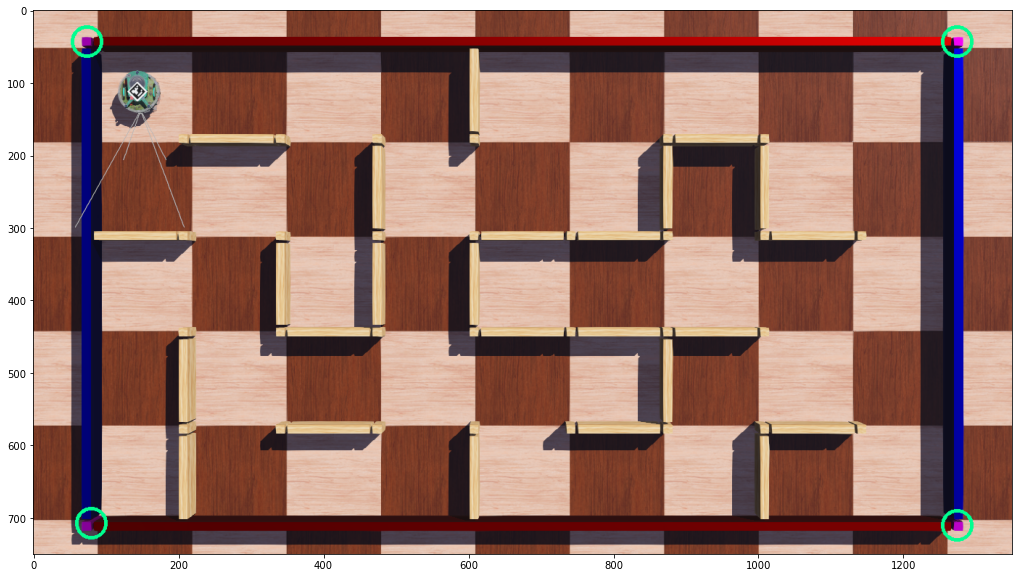

In [3]:
#Region of Interests
CR=[img_hsv[0:375, 0:338],img_hsv[375:750, 0:338],img_hsv[0:375, 1012:1350],img_hsv[375:750, 1012:1350] ]

#Thresholding Ranges
lower = np.array([145, 200, 70])
upper = np.array([150, 255, 255])

#Analysis Vectors
m=[]
C=[]
e=[]

#Dilation Kernel
k=np.ones((3,3),np.uint8)

#Region Check
for i in range(len(CR)):
    m.append(cv2.inRange(CR[i], lower, upper)) #Threshold Mask
    edges = cv2.Canny(m[i], threshold1 = 50, threshold2 = 100, apertureSize = 3) #Canny edge finder for Cornerstones
    _, contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Create Contour Shape based on Canny edges
    #Clean Noise Filled Contours
    while len(contours)!=1:
            m[i]=cv2.dilate(m[i],k,iterations=1) #Dilate 
            edges = cv2.Canny(m[i], threshold1 = 50, threshold2 = 100, apertureSize = 3) #Re-edge
            _, contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Re-contour

    #Center Finder       
    centers = [None]*len(contours)
    for j, c in enumerate(contours):
        centers[j], _ = cv2.minEnclosingCircle(c)
        C.append([int(centers[0][0]),(int(centers[0][1]))])

 #Rescale points for whole map
C[1][1] = C[1][1]+375    
C[2][0] = C[2][0]+1012  
C[3][1] = C[3][1]+375  
C[3][0] = C[3][0]+1012  

#Draw Locators
img_corner = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for i, c in enumerate(C):
    cv2.circle(img_corner, (C[i][0], C[i][1]), int(20), (0,255,144), 3)

#Plot Image
plt.figure(figsize = (18, 10)) #Plot Figure Size
plt.imshow(img_corner) #holds image to show
plt.show() #shows image

## Perspective Transform

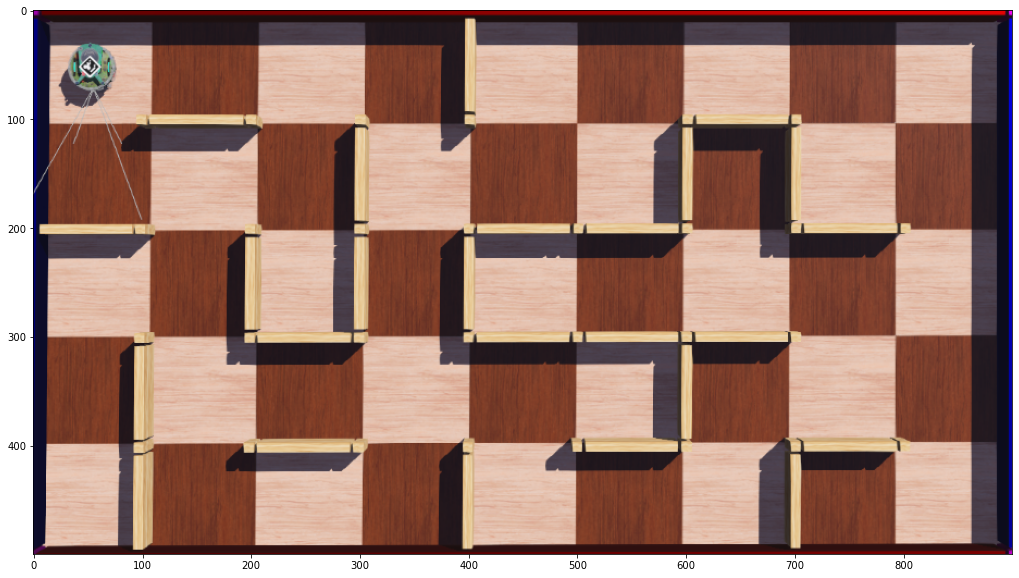

In [4]:
#Points
pts1 = np.float32(C) #Cornerstone Centers 
pts2 = np.float32([[0,0],[0,500],[900,0],[900,500]]) #New Position

#Transform
H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
dst = cv2.warpPerspective(img_rgb, H, (900,500)) #New Image

#Plot Image
plt.figure(figsize = (18, 10)) #Plot Figure Size
plt.imshow(dst) #holds image to show
plt.show()

## Internal Wall Locator

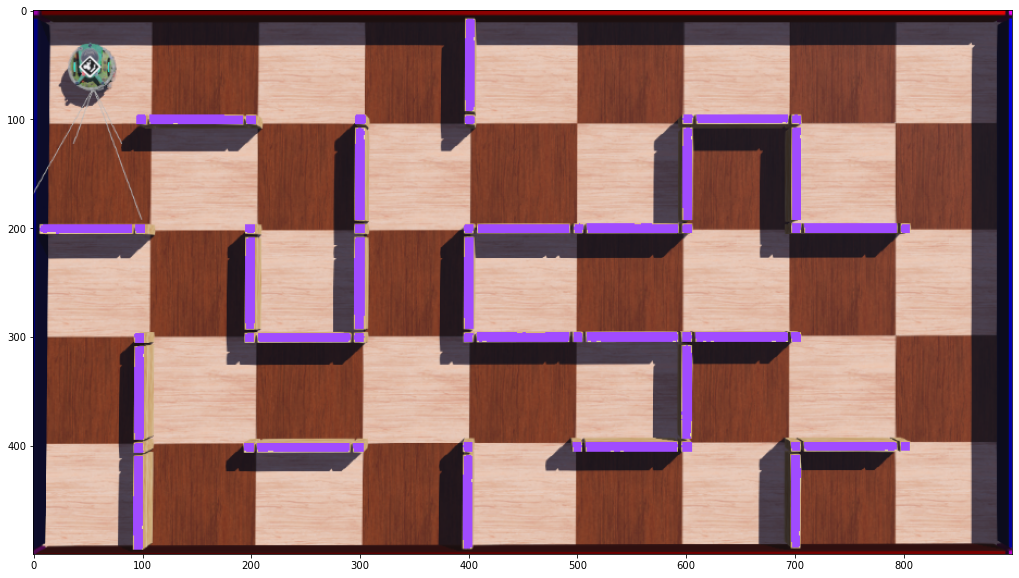

In [5]:
#Used Transformed Image
dst_hsv=cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)

#Threshold Mask (Lower/Upper HSV Values based on Inner Wall Colour Range)
lower2 = np.array([17, 0, 221])
upper2 = np.array([19, 255, 255])
mask2 = cv2.inRange(dst_hsv, lower2, upper2)

#Morphological Clean
mask2=cv2.morphologyEx(mask2,cv2.MORPH_CLOSE,k) 

#Overlaying Masks
mask2inv=cv2.bitwise_not(mask2)
maskC=cv2.cvtColor(mask2, cv2.COLOR_GRAY2RGB)
maskC[np.where((maskC==[255,255,255]).all(axis=2))]=[160,75,255]

#Overlay
img1_bg = cv2.bitwise_and(dst,dst,mask = mask2inv)
img2_fg = cv2.bitwise_and(maskC,maskC,mask = mask2)
out_img = cv2.add(img1_bg,img2_fg)

#Plot Image
plt.figure(figsize = (18, 10)) #Plot Figure Size
plt.imshow(out_img)
plt.show()

## Robot Locator

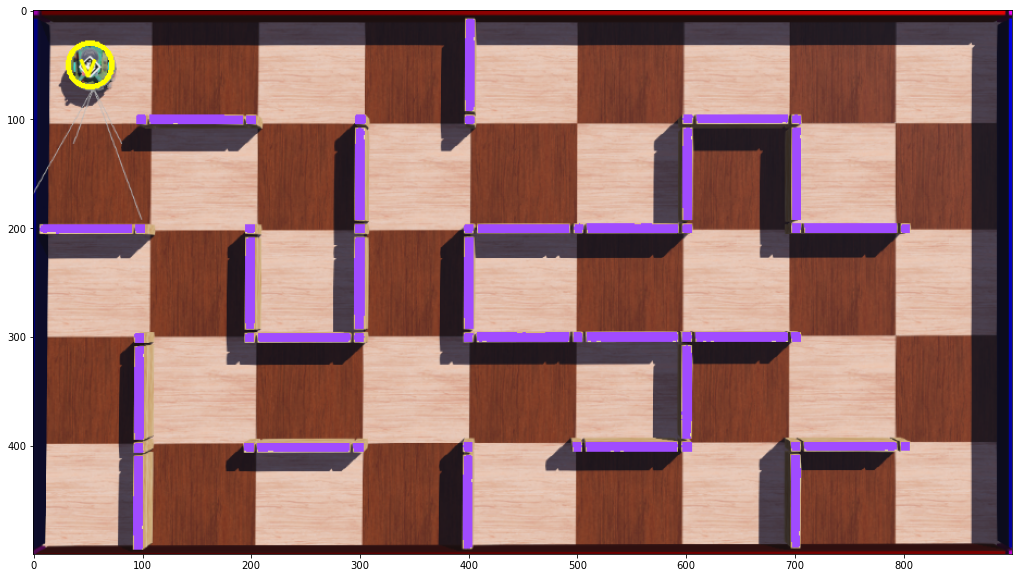

In [6]:
#Location 
output=out_img.copy()
#Threshold Mask (Lower/Upper HSV Values based on Robot Colour Range)
lower2 = np.array([35, 16, 72])
upper2 = np.array([113, 173, 255])
maskn = cv2.inRange(dst_hsv, lower2, upper2)

#Morphological Clean
k=np.ones((3,3),np.uint8)
mask3=cv2.erode(maskn,k,iterations=1)
mask3=cv2.dilate(mask3,k,iterations=8)

#Contour Find
edges2 = cv2.Canny(mask3, threshold1 = 50, threshold2 = 100, apertureSize = 3) #Canny edge finder for Circle
_, contours2, _ = cv2.findContours(edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Create Contour Shape based on Canny edges

#Centre Location
for i, c in enumerate(contours2):
    M=cv2.moments(c)
    cx=int(M['m10']/M['m00'])
    cy=int(M['m01']/M['m00'])

#Draw Locator
output=cv2.circle(output, (cx, cy), 20, (255,255,0), 3)

#Direction
ROI_rgb = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)

#Perspective Transform
dst2 = cv2.warpPerspective(ROI_rgb, H, (900,500))

#Marker Initialisation
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
parameters =  cv2.aruco.DetectorParameters_create()
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(dst2, dictionary, parameters=parameters)

#Direction Identifier
MDiffx=markerCorners[0][0][0][0]-markerCorners[0][0][2][0]
MDiffY=markerCorners[0][0][0][1]-markerCorners[0][0][2][1]
if MDiffY > 5:
    Dir='v'
elif MDiffY < -5:
    Dir='^'
elif MDiffx > 5:
    Dir='>'
elif MDiffx < -5:
    Dir='<'
else:
    Dir="x"

#Draw Direction
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(output, Dir, (cx-10,cy+10), font, 1, (255,255,0), 2, cv2.LINE_AA)

#Plot Image
plt.figure(figsize = (18, 10)) #Plot Figure Size
plt.imshow(output)
plt.show()


## Map Conversion

In [7]:
#Mapout
row=list(range(0,401,100))
col=list(range(0,801,100))

#Wall check Tolerance
check=list(range(70,131))

#Main Mask
outhsv=cv2.cvtColor(out_img,cv2.COLOR_RGB2HSV) #Fix Robot
lower3 = np.array([134, 10, 180])
upper3 = np.array([138, 255, 255])
mask4 = cv2.inRange(outhsv, lower3, upper3)

#Clean Map and Write
f = open(Map, "w")
f.write(" --- --- --- --- --- --- --- --- --- ") #Top Wall

for i in row:
    f.write("\n")
    f.write("|") #Leftmost Wall

    for j in col:
        #Robot Position
        if (cx in range(j,j+100)) and (cy in range(i,i+100)):
            f.write(" ")
            f.write(Dir)
            f.write(" ")
        else:
            f.write("   ")
            #Vertical Walls
        if j==800:
            f.write("|") #Rightmost Wall
        else:
            for k in check:
                if mask4[i+50,j+k]==255:
                    d=True
                    break
                else:
                    d=False
            if d == True:
                f.write("|") #Wall Found
            else:
                f.write(" ") #No Wall fOUND

    f.write("\n")

    if i==400:
        break
    #Horizontal Walls
    f.write(" ") #Left wall Spacing
    for j in col:
        for k in check:
            if mask4[i+k,j+50]==255:
                d=True
                break
            else:
                d=False
        if d == True:
            f.write("--- ") #Wall Found
        else:
            f.write("    ") #No Wall Found
f.write(" --- --- --- --- --- --- --- --- --- \n")#Bottom Wall
f.close()

#Show Map
f = open(Map, "r")
print(f.read())


--- --- --- --- --- --- --- --- --- 
| v             |                   |
     ---                 ---         
|           |           |   |       |
 ---             --- ---     ---     
|       |   |   |                   |
         ---     --- --- ---         
|   |                   |           |
         ---         ---     ---     
|   |           |           |       |
 --- --- --- --- --- --- --- --- --- 

